# Chapter 3 - Classification

## Setup

In [1]:
# Python >=3.5 is required
import sys
assert sys.version_info >= (3,5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

# Common imports
import os
import numpy as np

# to make notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
!matplotlib inline

# Where to save the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'classification'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

/bin/sh: matplotlib: command not found


## MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

(-0.5, 27.5, 27.5, -0.5)

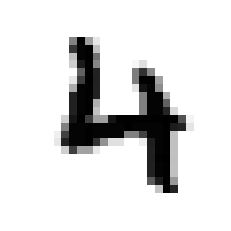

In [6]:
# Taking a peek at the X values
some_digit = X[37000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')

In [7]:
y[37000]

'4'

In [8]:
y = y.astype(np.uint8)

In [9]:
y[37000]

4

In [10]:
# Making a Test and a Train Sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
# Shuffle the training set for garanteing similarity between cross-validation folds (not true for timeseries data!)
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

In [12]:
# Creating target vectors for this classification: 5 or not 5
y_train_5 = (y_train == 5) # True, false list
y_test_5 = (y_test == 5)

In [13]:
y_train_5[y_train_5 == True].shape

(5421,)

In [14]:
# Training the classifier with a Stochastic Gradient Descent (SGD) -> This classifier is well suited for Online 
# Learning
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([False])

In [16]:
sgd_clf.predict([X[0]])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8678 , 0.88195, 0.86965])

In [18]:
# Comparison with the dumbest model
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1),dtype=bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90745, 0.9125 ])

* For skewed datasets accuracy scoring is generally not the preferred performance measurement for classifiers

### Confusion Matrix

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
# Building the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]])

### Precision and Recall

In [22]:
from sklearn.metrics import precision_score, recall_score

ps = precision_score(y_train_5, y_train_pred)
ps

0.754513244474439

In [23]:
rs = recall_score(y_train_5, y_train_pred)
rs

0.8249400479616307

In [24]:
# My F1 score, the harmonic mean of these two scores -> much more weight to low values -> only get high F1 if both
# scores are high
f1 = 2 * ((ps * rs)/(ps + rs))
f1

0.7881565033486078

In [25]:
# Or...
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7881565033486078

"The f1 score favours classifiers that have similar precision and recall." But, increasing precision reduces recall and vice-versa: _precision/recall_ tradeoff.

### Precision/Recall Tradeoff

In [26]:
# As a threshold increase so does the precision, but in detriment of the recall
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8,3))    
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])

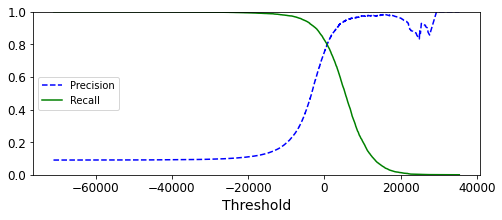

In [29]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds);

Text(0, 0.5, 'Precision')

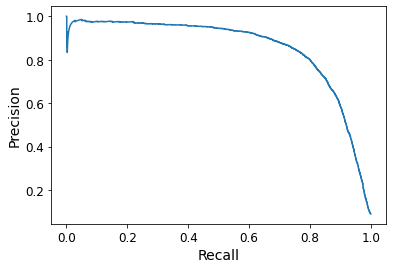

In [30]:
# Plotting precision against recall
plt.plot(recalls, precisions);
plt.xlabel('Recall')
plt.ylabel('Precision')

<font color=blue>"Lets reach 99% precision": "At what recall?"</font>

In [31]:
# Suppose you want 90% precision
y_train_pred_90 = (y_scores > 1500)

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.8397070789259561

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.7614831211953514

### The ROC Curve

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # curve of a purely random classifier
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

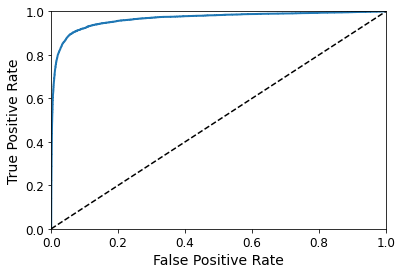

In [36]:
plot_roc_curve(fpr, tpr)

In [37]:
# AUC: area under the curve score
# Perfect classifier ROC_AUC = 1
# Random classifier ROC_AUC = 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9660259463088996

In [38]:
# RandomForestClassifier and Comparisons
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [39]:
# ROC curve needs scores not probabilities, so...
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

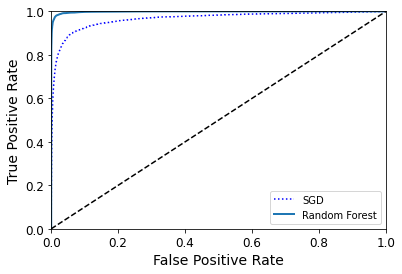

In [40]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')

In [41]:
# Incredible, RandomForest performs way better than the StochasticGradientDescent method
roc_auc_score(y_train_5, y_scores_forest)

0.9983631764491033

In [42]:
y_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [43]:
precision_score(y_train_5, y_forest_pred)

0.9890893831305078

In [44]:
recall_score(y_train_5, y_forest_pred)

0.8695812580704667

## Multiclass Classification

In [45]:
# Scikit tries to guess if you are trying one of the following strategies for Multiclass Classification
# OvA, OvO
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [55]:
sgd_clf.predict([X[0]])

array([3], dtype=uint8)

(-0.5, 27.5, 27.5, -0.5)

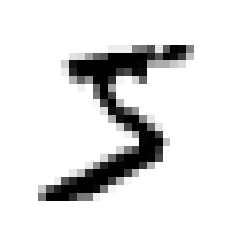

In [56]:
# Taking a peek at the X values
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')

In [57]:
print(y[0])

5


In [58]:
# Omitting the OvO and OvR classifiers
# Random Forest Classifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([X[0]])

array([5], dtype=uint8)

In [60]:
forest_clf.predict_proba([X[0]])

array([[0.01, 0.  , 0.03, 0.06, 0.  , 0.88, 0.  , 0.01, 0.01, 0.  ]])

In [62]:
# Evaluating the classifiers
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8678 , 0.88195, 0.86965])

In [63]:
# The classifier can perform much better if inputs are scaled
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90425, 0.9031 , 0.8903 ])

### Error Analysis

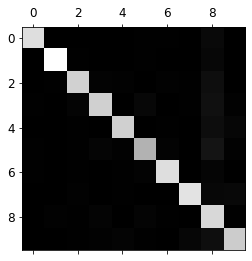

In [64]:
# Confusion Matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray);

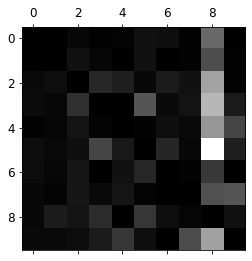

In [65]:
# Focusing on errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [66]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row+1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis('off')

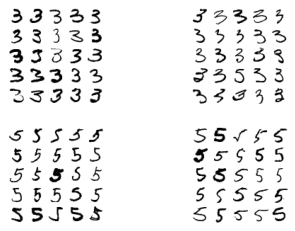

In [69]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

## Multilabel Classification

In [70]:
# If there are outputs multiple classes for each instance: KNN -> Recognize several people in one figure, e.g..
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel[:10]

array([[ True,  True],
       [False,  True],
       [ True, False],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [False, False]])

In [71]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [72]:
knn_clf.predict([X[0]])

array([[False,  True]])

In [ ]:
# Evaluating through f1 score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

## Multioutput Classification

In [ ]:
# It is a generalization of multilabel classification where  each label can be multiclass (i.e. more than two 
# possible values).
noise = np.random.randint(0,100, (len(X_train)), 784)
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test)), 784)
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

In [ ]:
some_digit_image = clean_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')